In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
from FindDataFunctions import *
import scipy.integrate
import pprint
import re
from matplotlib.ticker import MaxNLocator

In [2]:
def readData(path):
    saved_path = os.path.join(path, "saved.pkl")
    if os.path.isfile(saved_path):
        df = pd.read_pickle(saved_path)
    else:
        cols = ["drt", "occupancy", "occupancy_all", "detour", "servability", "req_mean_dist", "drt_travel_time_normalized",
        "drt_ride_time", "drt_wait_time_normalized", "drt_distance", "cummulative_dist_drt",
        "cummulative_dist_drt_unshared", "pkm_drt", "drt_wait_time","drt_wait_time_median", "travel_time_unshared"]
        
        bim_dirs = getDirs(path, ["dist", "frac_comm_orig_dest", "drt", "unimodal"], ["2000", None, None, None])
        df = pd.DataFrame(np.full((len(bim_dirs), len(cols)), np.nan), columns=cols)
                            
        for i,e in enumerate(bim_dirs):
            row = df.iloc[i,:]
            try:
                row["drt"] = int(e[2])
                dic = e[-1]
                row.loc["occupancy"], _ = getDrtOccupandyAndStandingFrac(dic, False, False)
                row.loc["occupancy_all"], _ = getDrtOccupandyAndStandingFrac(dic, False, True)
                df_detour = getDrtDetours(dic)
                row.loc["detour"] = df_detour["distanceDetour"].mean()
                trip_succ = getTripSuccess(dic)
                row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
                df_persons = getPersons(dic)
                row.loc["req_mean_dist"] = df_persons["mean_dist"].mean()
                drt_trips, drt_trips_perperson = getDrtTrips(dic)
                row.loc["cummulative_dist_drt"] = getDrtVehicleDistances(dic).sum()
                row.loc["cummulative_dist_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
                df_detour = df_detour.set_index("person")
                row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
                row.loc["travel_time_unshared"] = df_detour["unsharedTime"].mean()
                row.loc["drt_wait_time"] = drt_trips_perperson["waitTime"].mean()
                row.loc["drt_wait_time_median"] = drt_trips_perperson["waitTime"].median()
                drt_travel_time = drt_trips_perperson["travelTime"] + drt_trips_perperson["waitTime"]
                row.loc["drt_travel_time_normalized"] = (drt_travel_time/df_detour["unsharedTime"]).mean()
                row.loc["drt_ride_time"] = drt_trips_perperson["travelTime"].mean() # Travel Time in DRT contrib
                # is ride time in matsim convention
                row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
                _, row.loc["pkm_drt"] = getModeStats(dic, [], ["drt"])
            except KeyError:
                print("KeyError")
                pass
            print("-----")
        df.to_pickle(saved_path)

    print("loaded data")
    return df

In [3]:
rootpath = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/"
betas = ["0","300","600","900","1200"]
# betas = ["600"]

In [4]:
dataset = []
req_mean_dists = []
for beta in betas:
    path = os.path.join(rootpath, "100GridSpacing"+beta+"Beta/100000reqs/")
    data = readData(path).sort_values("drt")
    req_mean_dists.append(data["req_mean_dist"].mean())
    dataset.append(data)
    
#     display(data.rename(columns={"drt_travel_time": "drt_ride_time",
#                                 "":"",
#                                 "":""}).head())
# #     saved_path = os.path.join(path, "saved.pkl")
# #     df.to_pickle(saved_path)

req_mean_dist = sum(req_mean_dists)/len(req_mean_dists)

loaded data
loaded data
loaded data
loaded data
loaded data


In [5]:
# cummulative_car_dist = 1
# tt_car = 1
# cummulative_drt_bimodal_rescaled = cummulative_drt_bimodal / cummulative_car_dist
# tt_bimodal_rescaled = tt_bimodal / tt_car
# wait_times_rescaled = wait_times / tt_car

# cummulative_drt_bimodal_rescaled2 = cummulative_drt_bimodal2 / cummulative_car_dist
# tt_bimodal_rescaled2 = tt_bimodal2 / tt_car
# wait_times_rescaled2 = wait_times2 / tt_car

In [6]:
def finiteDiffBound3(f, dx):
    return (-3/2*f[0] + 2*f[1] - 1/2*f[2])/dx

def finiteDiffBound4(f, dx):
    return (2*f[0] - 5*f[1] + 4*f[2] - f[3])/dx**2

def finiteDiffBound5(f, dx):
    return (-5/2*f[0] + 9*f[1] - 12*f[2] + 7*f[3] - 3/2*f[4])/dx**3

In [7]:
# rejection_rate = 1 - serviced_fracts
# rejection_rate2 = 1 - serviced_fracts2
# rej_grad = np.gradient(rejection_rate, fleet_list)
# idx_min_grad = np.argmin(rej_grad) + 1
# crit_fleetsize = fleet_list[idx_min_grad]# + 0.1
# crit_rej_offset = rejection_rate[idx_min_grad]# - 0.01

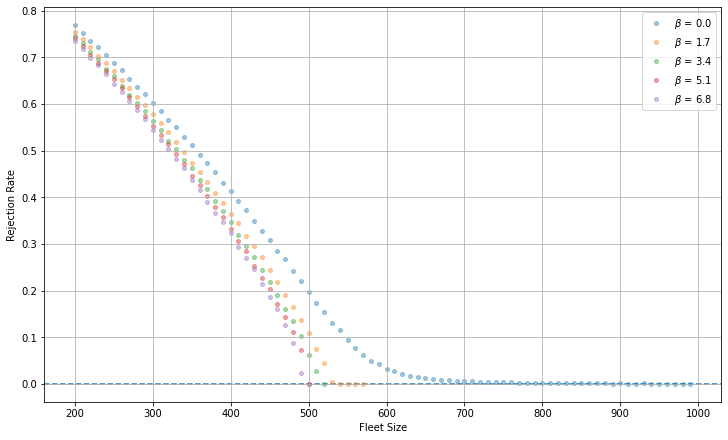

In [15]:
%matplotlib inline

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))

def turn_one_more_true(x):
    mask = x.nonzero()[0]
    if len(mask) != 0 and mask[-1]+1 < len(x):
        x[mask[-1]+1] = True
    return x

for beta,data in zip(betas,dataset):
    rej_rate = 1 - data["servability"]
    mask = rej_rate.to_numpy() != 0
    mask = turn_one_more_true(mask)
#     mask = np.s_[:]
    beta_norm = round(float(beta)*(30/3.6)/req_mean_dist, 1)
    ax.plot(data[mask]["drt"], rej_rate[mask], "o", ms=4, label=fr"$\beta$ = {beta_norm}", alpha=0.4, zorder=1) 

# ax.axvline(crit_fleetsize, ls='--', c='orange')
# m = (serviced_fracts[-1] - serviced_fracts[0])/100
# b = serviced_fracts[0]
# new_x = np.array([180, 380])
# ax.plot(new_x, m*(new_x-180)+b)

ax.set_xlabel("Fleet Size")
ax.set_ylabel("Rejection Rate")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# fig.suptitle(r"$125\cdot 10^3$" + " requests " + r"$(\nu={}\,\mathrm{{s}}^{{-1}})$".format(round(125*10**3/(10*3600), 3)))
# fig.suptitle(r"$10^5$" + " reqs " + r"$(f={})$".format(round(10**5/9*1/15,1)))

# ax.set_ylim(0,1.1)
ax.axhline(0, ls="--", zorder=0)
ax.grid()
ax.legend()

# fig.savefig("125e3ReqsUnimodal.jpg", dpi=200)
# fig.savefig("VaryFleetSizeTTConstraint.png", dpi=200)
# fig.savefig("figures/VaryFleetSizeTTConstraintNoQueueCheck.jpg", dpi=200)
# plt.savefig("figures/VaryFleetSizeSelInsSearch.jpg", dpi=200)
# plt.savefig("figures/DrtRejectionRateUnimodal", dpi=300)
plt.show()

# Who is being rejected?

loaded data
loaded data
loaded data
loaded data
loaded data
loaded data
loaded data
loaded data


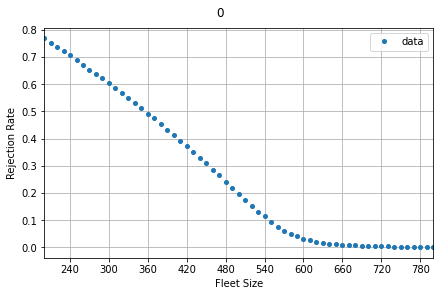

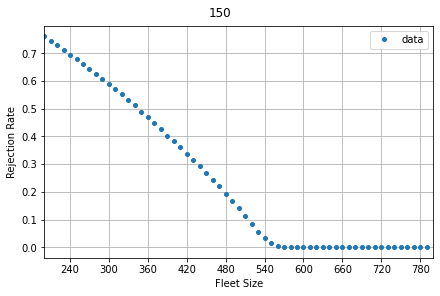

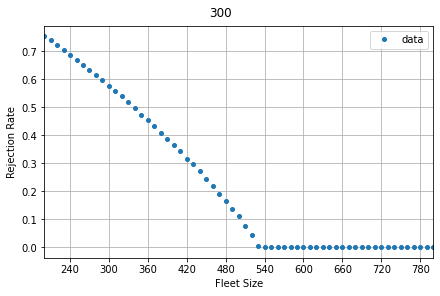

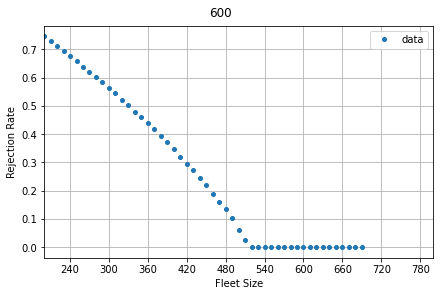

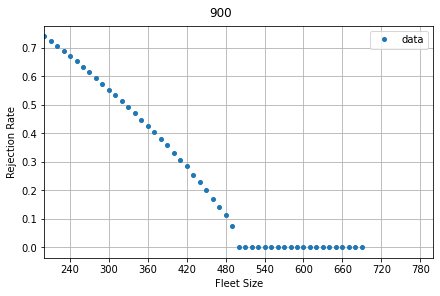

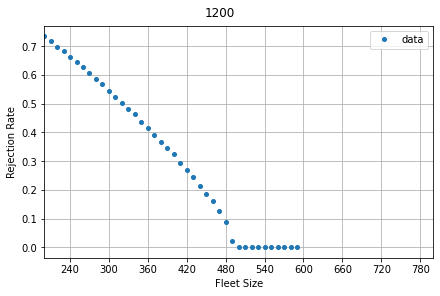

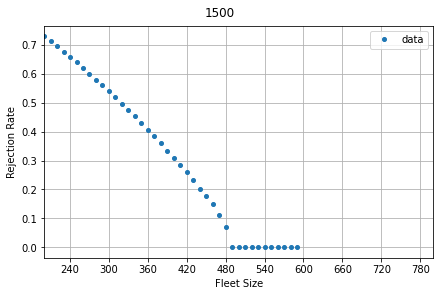

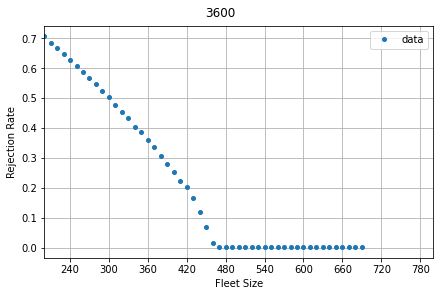

In [9]:
%matplotlib inline

for beta in ["0", "150", "300", "600", "900", "1200", "1500", "3600"]:
    path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/100GridSpacing"+beta+"Beta/100000reqs/"
    data = readData(path)
#     data = data[(data["drt"] < 800) & (data["drt"] > 200)]
    fig, ax = plt.subplots(constrained_layout=True)

    ax.plot(data["drt"], 1 - data["servability"], "o", ms=4, label="data")

    ax.set_xlim(200,800)
    ax.set_xlabel("Fleet Size")
    ax.set_ylabel("Rejection Rate")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.grid()
    ax.legend()
    fig.suptitle(beta)

plt.show()

<IPython.core.display.Javascript object>


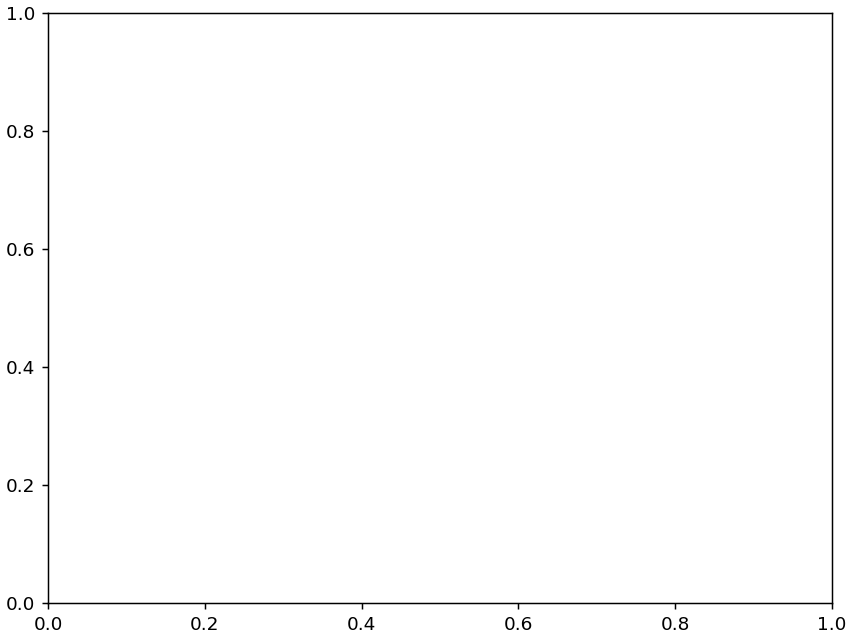

NameError: name 'crit_fleetsize' is not defined

In [13]:
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
%matplotlib notebook

fig, ax = plt.subplots(constrained_layout=True)

order_param = (crit_fleetsize-fleet_list)#/crit_fleetsize
idx = np.where(order_param > 0)
order_param = order_param[idx][::-1]
rejection_rate_reordered = rejection_rate[idx][::-1]

x_log = np.log(order_param)
y_log = np.log(rejection_rate_reordered-crit_rej_offset)
def linFunc(x, a, b):
    return a*x + b
popt, pcov = curve_fit(linFunc, x_log[:3], y_log[:3])
print(popt)
# print("Critical Exponent: ", popt[0])
# print("Crit. Exp. (Finite Differences): ", finiteDiffBound4(y_log[:4], x_log[3] - x_log[0]))

ax.plot(order_param, rejection_rate_reordered-crit_rej_offset, "o", ms=2)
x_plotlims = ax.get_xlim()
y_plotlims = ax.get_ylim()
ax.plot(order_param, np.exp(popt[1])*order_param**popt[0], ls='--')

# ax.set_xlim(x_plotlims)
# ax.set_ylim(y_plotlims)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Fleet Size")
ax.set_ylabel("Rejection Rate")
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# fig.suptitle(r"$125\cdot 10^3$" + " requests " + r"$(\nu={}\,\mathrm{{s}}^{{-1}})$".format(round(125*10**3/(10*3600), 3)))

# fig.savefig("125e3ReqsUnimodal.jpg", dpi=200)
plt.show()

In [28]:
idx = 0
data = dataset[idx]
print(betas[idx])
display(data)

0


,drt,occupancy,occupancy_all,detour,servability,req_mean_dist,drt_travel_time_normalized,drt_ride_time,drt_wait_time_normalized,drt_distance,cummulative_dist_drt,cummulative_dist_drt_unshared,pkm_drt,drt_wait_time,drt_wait_time_median,travel_time_unshared
33,200.0,1.906435,1.785475,1.402812,0.23076,1467.783474,2.765174,557.090354,1.347586,4397.325346,5.238726e+07,7.013349e+07,101473.0,502.149029,517.0,381.081903
16,210.0,1.924665,1.797265,1.408241,0.24678,1467.783474,2.762080,550.584529,1.338284,4344.270571,5.498143e+07,7.369807e+07,107208.0,487.790866,500.0,374.423211
64,220.0,1.932952,1.803631,1.411157,0.26425,1467.783474,2.760832,540.577408,1.333522,4263.872389,5.753834e+07,7.722698e+07,112673.0,475.187209,485.0,366.400605
45,230.0,1.904362,1.783086,1.408804,0.27728,1467.783474,2.762182,532.456362,1.337528,4200.503676,6.008876e+07,7.994179e+07,116472.0,469.555071,479.0,361.458417
42,240.0,1.911090,1.788092,1.414072,0.29418,1467.783474,2.758780,525.158610,1.328426,4141.875237,6.263868e+07,8.320363e+07,121846.0,456.536610,464.0,354.596743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,950.0,1.852126,0.964050,1.471035,0.99952,1467.911784,2.363320,329.863545,0.864837,2586.522485,1.368979e+08,1.659064e+08,258528.0,182.479750,119.0,208.029754
50,960.0,1.855828,0.954688,1.472197,0.99935,1467.911784,2.365777,330.154831,0.865997,2588.732776,1.369924e+08,1.658992e+08,258705.0,182.694091,119.0,208.056146
78,970.0,1.849777,0.943431,1.470467,0.99943,1467.911784,2.357777,329.633941,0.859759,2584.707513,1.368364e+08,1.659040e+08,258323.0,182.041223,117.0,208.045656
56,980.0,1.857421,0.936194,1.473025,0.99950,1467.911784,2.356753,330.454367,0.856238,2591.100407,1.366349e+08,1.659053e+08,258981.0,180.934697,117.0,208.032746


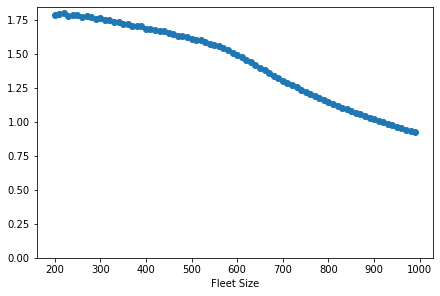

In [29]:
%matplotlib inline
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(data["drt"], data["occupancy_all"], 'o-')
# ax.plot(fleet_list2, av_drt_occs2, 'o-')

ax.set_xlabel("Fleet Size")
ax.set_ylim(0,None)

plt.show()

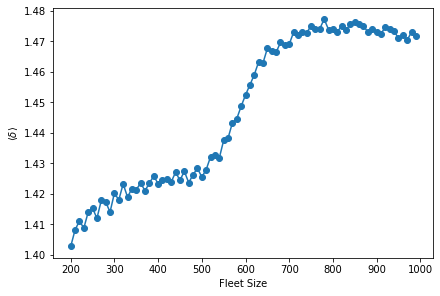

In [46]:
%matplotlib inline

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(data["drt"], data["detour"], 'o-')
# ax.plot(fleet_list2, av_detours2, 'o-')

ax.set_xlabel("Fleet Size")
ax.set_ylabel(r"$\langle\delta\rangle$")
# ax.set_ylim(0,av_detours.max()*1.1)

plt.show()

NameError: name 'fleet_list' is not defined

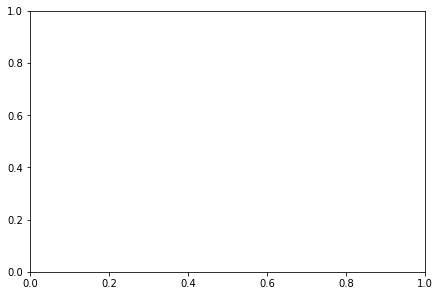

In [116]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(fleet_list, av_drt_occs/av_detours, 'o-')
ax.plot(fleet_list2, av_drt_occs2/av_detours2, 'o-')

ax.set_xlabel("Fleet Size")

plt.show()

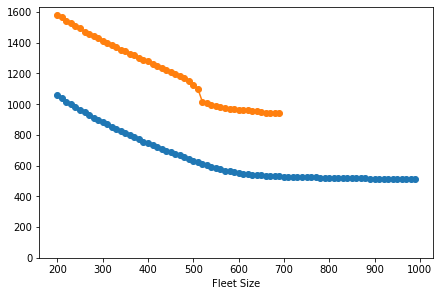

In [20]:
fig, ax = plt.subplots(constrained_layout=True)

def fitFunc(x,a,b,c):
    return a/x**b + c

# popt, pcov = curve_fit(fitFunc, fleet_list2, tt_bimodal_rescaled2, p0=[100, 0.5, 500])
#Normalize by TT for private car
ax.plot(fleet_list, tt_bimodal_rescaled, 'o-')
ax.plot(fleet_list2, tt_bimodal_rescaled2, 'o-')
# ax.plot(fleet_list2, fitFunc(fleet_list2, *popt))
# print(popt)

ax.set_ylim(0,None)
ax.set_xlabel("Fleet Size")

plt.show()

In [99]:
v_drt = (30/3.6)
drt_wait_norm = data["drt_wait_time"]/(data["req_mean_dist"]/v_drt)
# drt_wait_norm = data["drt_wait_time_normalized"]
print(drt_wait_norm)

33    2.850949
16    2.769430
64    2.697873
45    2.665897
42    2.591984
        ...   
23    1.035937
50    1.037154
78    1.033448
56    1.027166
73    1.032849
Length: 80, dtype: float64


In [20]:
fleet_apr_no_rej = data["drt"].to_numpy()[np.nonzero(np.isclose(data["servability"].to_numpy(), 1, atol=0.01))[0][0]]

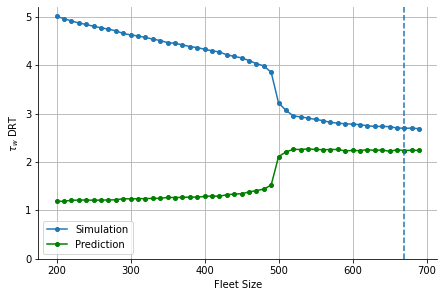

In [27]:
%matplotlib inline
fig, ax = plt.subplots(constrained_layout=True)

def fitFunc(x,a, b, c):
    return a*np.exp(-b*x)+c

# popt, pcov = curve_fit(fitFunc, fleet_list, wait_times_rescaled)
v_drt = (30/3.6)
drt_rt = data["detour"]*req_mean_dist/v_drt
drt_rt = data["drt_ride_time"]
drt_rt = req_mean_dist / v_drt
drt_rt_norm = data["detour"]#*data["req_mean_dist"].mean()/v_drt
# drt_rt_norm = data["drt_ride_time"] / data["travel_time_unshared"].mean()
drt_wait_norm = data["drt_wait_time"] / data["travel_time_unshared"].mean()

#Normalize by TT for private car
ax.plot(data["drt"], drt_wait_norm, 'o-', ms=4, label="Simulation")
ax.plot(data["drt"], data["occupancy"]*drt_rt_norm/3, "o-", ms=4, color="green", label="Prediction")
# ax.plot(data["drt"], data["drt_wait_time"], 'o-', ms=4, label="Data")
# ax.plot(data["drt"], data["occupancy"]*drt_rt/3, "o-", ms=4, color="green", label="Prediction")
# ax.plot(data["drt"], data["drt_ride_time"], "o-", ms=4)
# ax.plot(data["drt"], drt_rt, "o-", ms=4, color="green", label="Prediction")
# ax.plot(fleet_list2, wait_times_rescaled2, 'o-')
# ax.plot(fleet_list, fitFunc(fleet_list, *popt))
# print(popt)
ax.axvline(fleet_apr_no_rej, ls="--")

ax.set_xlabel("Fleet Size")
ax.set_ylabel(r"$\tau_w$ DRT")
ax.set_ylim(0,None)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid()
ax.legend()

fig.savefig("Figures/DrtWaitingTimeCompUnimodal.pgf")

plt.show()

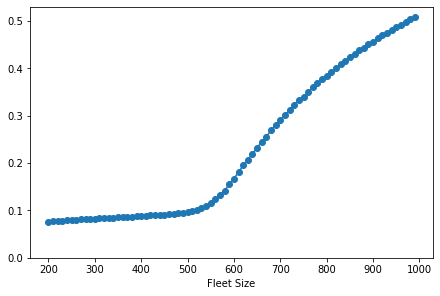

In [24]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(fleet_list, standing_fractions, 'o-')
# ax.plot(fleet_list2, standing_fractions2, 'o-')

ax.set_xlabel("Fleet Size")
ax.set_ylim(0,None)

# fig.savefig("figures/IdlingFractionUnimodal", dpi=300)
plt.show()

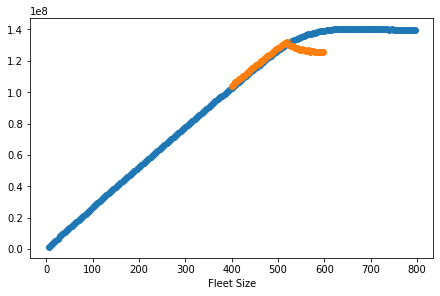

In [310]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(fleet_list, cummulative_drt_bimodal_rescaled, 'o-')
ax.plot(fleet_list2, cummulative_drt_bimodal_rescaled2, 'o-')

ax.set_xlabel("Fleet Size")

plt.show()

In [ ]:
def isParetoEfficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

In [ ]:
costs = np.stack((cummulative_drt_bimodal_rescaled, tt_bimodal_rescaled), axis=1)

In [ ]:
%matplotlib inline

pareto_efficient = isParetoEfficient(costs)
fig, ax = plt.subplots(constrained_layout=True)

scatter = ax.scatter(cummulative_drt_bimodal_rescaled, tt_bimodal_rescaled, c=pareto_efficient)
# ax.plot(cummulative_drt_bimodal_rescaled, tt_bimodal_rescaled)
handles, labels = scatter.legend_elements()
labels = ["pareto unoptimal", "pareto optimal"]

ax.set_xlabel("driven_distance_bimodal / driven_distance_car")
ax.set_ylabel("tt_bimodal / tt_car")
ax.legend(handles, labels)
# fig.colorbar(scatter)

plt.show()

In [ ]:
x = np.linspace(0.0001,10,100)
y = np.sqrt(x)
log_x = np.log(x)
log_y = np.log(y)

plt.figure()

plt.plot(log_x,log_y)
plt.grid()

plt.show()

print("Exp: 1/2")

In [2]:
# bim_dirs = getDirs(path, ["dist", "drt", "unimodal"], ["2000", None, None])
# bim_dirs2 = getDirs(path2, ["dist", "drt", "unimodal"], ["2000", None, None])
# bim_dirs = [e[-1] for e in bim_dirs]
# bim_dirs2 = [e[-1] for e in bim_dirs2]
# n_sims = len(bim_dirs)
# n_sims2 = len(bim_dirs2)
# pprint.pprint(bim_dirs)
# # print('\n---\n')
# # pprint.pprint(uni_dirs)
# print('\n---\n')
# # pprint.pprint(car_dir)

In [106]:
# data2 = np.empty((13, n_sims2))

# saved_path2 = os.path.join(path2, "saved.npy")
# if os.path.isfile(saved_path2):
#     data2 = np.load(saved_path2)
# else:
#     for i,dic in enumerate(bim_dirs2):
#         data2[0,i] = getFleetSize(dic["root"])
#         print("Fleet Size: ", data2[0,i])
#         trips = getTrips(dic, "unimodal")
#         drt_trips = getDrtTrips(dic)
#         trip_succ = getTripSuccess(dic)
#         data2[4,i], data2[11,i] = getDrtOccupandyAndStandingFrac(dic, False)
#         data2[3,i], _ = getDrtOccupandyAndStandingFrac(dic, True)
#         data2[2,i], _ = getDrtOccupandyAndStandingFrac(dic, False, True)
#         drt_detours = getDrtDetours(dic)
#         data2[1,i] = getDrtVehicleDistances(dic).sum()
#         data2[7,i] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
#         print("Servability: ", data2[7,i])
#         data2[9,i] = drt_detours.mean()
#         data2[10,i] = trips["trav_time"].mean()
#         data2[5,i] = trips["wait_time"].mean()
#         data2[6,i] = drt_trips["waitTime"].mean()
#         data2[12,i] = drt_trips["travelTime"].mean()

#         print("-----")
#     np.save(saved_path2, data2)
        
# fleet_list2 = data2[0,:]
# cummulative_drt_bimodal2 = data2[1,:]
# av_drt_occs2 = data2[2,:]
# av_drt_occs_non_empty2 = data2[3,:]
# av_drt_occs_non_standing2 = data2[4,:]
# wait_times2 = data2[5,:]
# wait_times_drt2 = data2[6,:]
# serviced_fracts2 = data2[7,:]
# av_pt_occs2 = data2[8,:]
# av_detours2 = data2[9,:]
# tt_bimodal2 = data2[10,:]
# standing_fractions2 = data2[11,:]
# drt_rt2 = data2[12,:]

# print("Loaded Data")